# Project Overview:

# Import and Reading Data

In [3]:
import math
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import datetime
from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.statespace.kalman_filter import MEMORY_CONSERVE
from statsmodels.tsa.statespace.tools import diff
import statsmodels.base.wrapper as wrap

from statsmodels.tsa.arima.estimators.yule_walker import yule_walker
from statsmodels.tsa.arima.estimators.burg import burg
from statsmodels.tsa.arima.estimators.hannan_rissanen import hannan_rissanen
from statsmodels.tsa.arima.estimators.innovations import (
    innovations, innovations_mle)
from statsmodels.tsa.arima.estimators.gls import gls as estimate_gls

from statsmodels.tsa.arima.specification import SARIMAXSpecification
import pandas.util.testing as tm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
print(sm.__version__)

0.11.0rc1


In [2]:
df = pd.read_csv (r'C:\Bitcoin Historical Data - Investing.com.csv')

In [4]:
df.head()

,Date,Price,Open,High,Low
0,"Jan 25, 2021","33,744.6","32,244.3","34,854.3","32,205.1"
1,"Jan 24, 2021","32,241.3","32,088.5","33,034.8","30,982.9"
2,"Jan 23, 2021","32,088.9","32,994.1","33,441.4","31,418.2"
3,"Jan 22, 2021","33,000.5","30,838.7","33,821.2","28,871.2"
4,"Jan 21, 2021","30,842.1","35,472.3","35,591.1","30,101.8"


In [5]:
df.shape

(32, 5)

In [6]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low'], dtype='object')

In [7]:
df.dtypes

Date     object
Price    object
Open     object
High     object
Low      object
dtype: object

# Data Preprocessing

In [8]:
def convert_currency(val):
    """
    Convert the string number value to a float
     - Remove $
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','').replace('$', '')
    return float(new_val)

In [9]:
df['Price'].apply(convert_currency)
df['Price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')
df['Price'] = df['Price'].apply(convert_currency)

In [10]:
df['Open'].apply(convert_currency)
df['Open'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')
df['Open'] = df['Open'].apply(convert_currency)

In [11]:
df['Low'].apply(convert_currency)
df['Low'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')
df['Low'] = df['Low'].apply(convert_currency)

In [12]:
df['High'].apply(convert_currency)
df['High'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')
df['High'] = df['High'].apply(convert_currency)

In [15]:
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
df["Date"] = df["Date"].dt.strftime('%Y%m%d').astype(float)

In [14]:
df.dtypes

Date     datetime64[ns]
Price           float64
Open            float64
High            float64
Low             float64
dtype: object

In [16]:
df.isnull().sum()

Date     0
Price    0
Open     0
High     0
Low      0
dtype: int64

# Prediction 

In [16]:
df = df[['Price']].copy ()

In [17]:
df.head(31)

,Price
0,33744.6
1,32241.3
2,32088.9
3,33000.5
4,30842.1
5,35476.3
6,36002.9
7,36613.2
8,35839.6
9,36019.5


# Test the P-Value

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
result = adfuller(df.Price.dropna())
print (f"ADF Statistic: {result[0]}")
print (f"P-value: {result[1]}")

ADF Statistic: -0.2678427725272912
P-value: 0.9299368910799347


In [20]:
from statsmodels.graphics.tsaplots import plot_acf

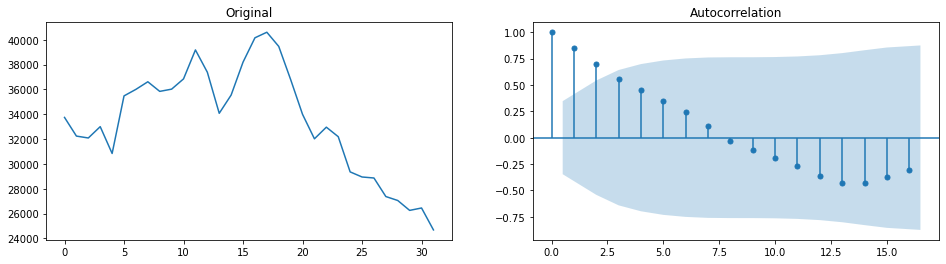

In [21]:
fig, (ax1, ax2) = plt.subplots (1,2, figsize = (16,4))
ax1.plot(df.Price)
ax1.set_title ("Original")
plot_acf(df.Price, ax=ax2);

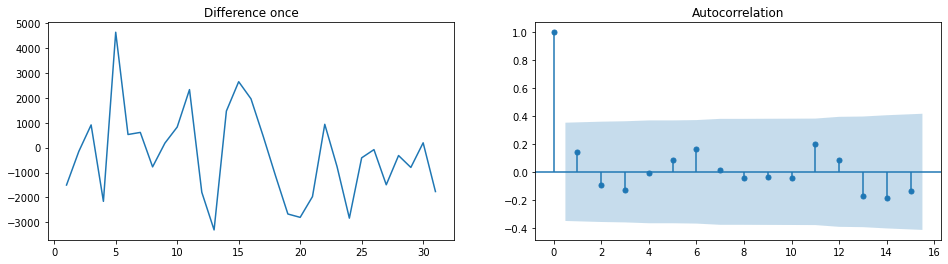

In [22]:
diff = df.Price.diff().dropna()
fig, (ax1, ax2) = plt.subplots (1,2, figsize = (16,4))
ax1.plot(diff)
ax1.set_title ("Difference once")
plot_acf(diff, ax=ax2);

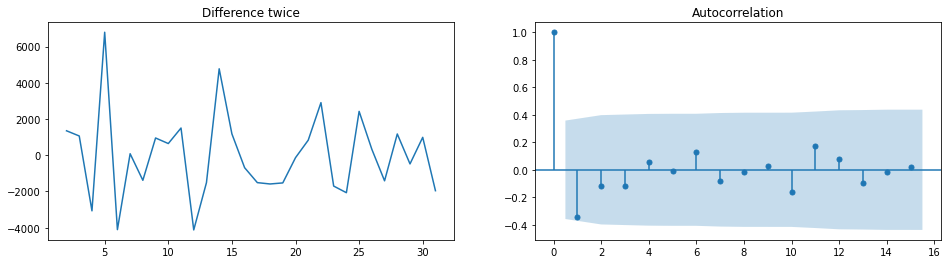

In [23]:
diff = df.Price.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots (1,2, figsize = (16,4))
ax1.plot(diff)
ax1.set_title ("Difference twice")
plot_acf(diff, ax=ax2);

# The order of differences(d)

In [24]:
from pmdarima.arima.utils import ndiffs

In [25]:
ndiffs (df.Price, test = "adf")
# d is 1

1

# q

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf

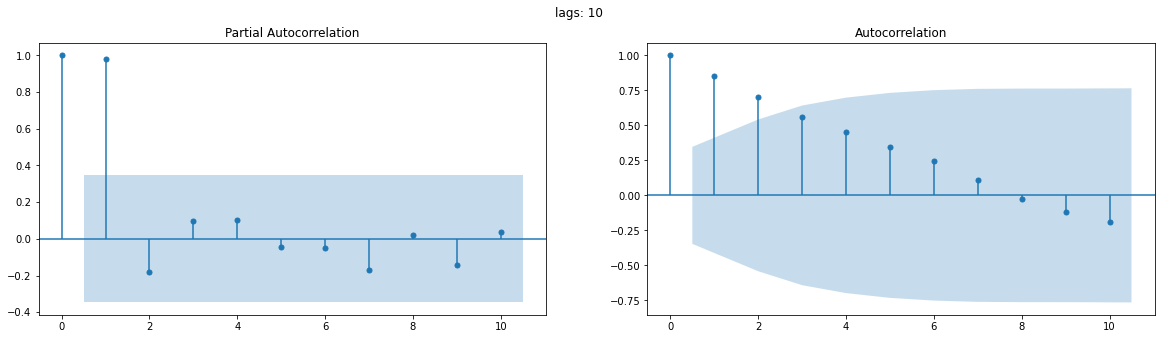

In [27]:
lags = 10
f, axarr = plt.subplots(1, 2, figsize=(20,5))
plot_pacf(df, method='ols', lags=lags, ax=axarr[0].axes)
plot_acf(df, lags=lags, ax=axarr[1].axes)
plt.suptitle('lags: {}'.format(lags))
plt.show()
# q = 3

# P

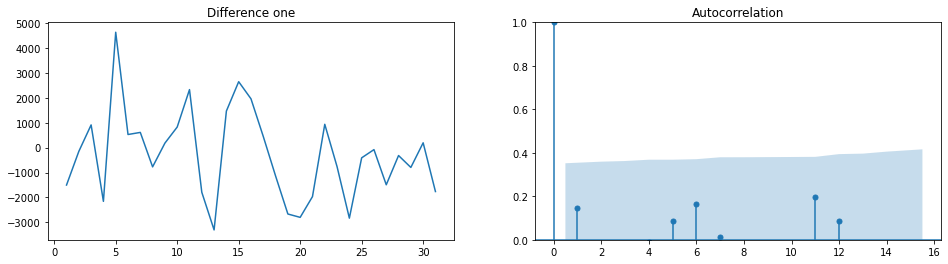

In [28]:
diff = df.Price.diff().dropna()

fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (16, 4))

ax1.plot(diff)
ax1.set_title ("Difference one")
ax2.set_ylim (0, 1)
plot_acf (diff, ax=ax2);

In [29]:
model = ARMA(df.Price, order=(3,1,5))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))
#ϕ is 1.29 which is what we chose as AR parameter in our first simulated model.

                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                   32
Model:                     ARMA(3, 1)   Log Likelihood                -284.985
Method:                       css-mle   S.D. of innovations           1726.835
Date:                Sun, 31 Jan 2021   AIC                            581.971
Time:                        23:45:45   BIC                            590.765
Sample:                             0   HQIC                           584.886
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.179e+04   3284.649      9.678      0.000    2.54e+04    3.82e+04
ar.L1.Price     1.2942      1.145      1.131      0.258      -0.949       3.538
ar.L2.Price    -0.4536      1.280     -0.354    

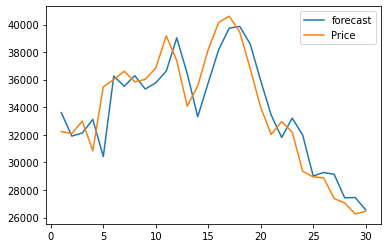

In [30]:
result.plot_predict(
     start = 1,
     end = 30,
     dynamic = False,
);